This is the banchmarking of the network architecture 

In [1]:
import sys
sys.path.append('../../..')

import os
os.environ['PYTHONPATH'] = '../../..'

In [2]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

## MedFL Imports 
## Network Manager Imports 
from Medfl.NetManager.node import Node
from Medfl.NetManager.network import Network
from Medfl.NetManager.dataset import DataSet
from Medfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *
from Medfl.LearningManager.flpipeline import *
from Medfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from Medfl.LearningManager.utils import *


C:\Users\HP User\AppData\Local\Temp\ipykernel_1980\3319853876.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-29 10:59:16,959	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
# DB Creation 
!python ../../../scripts/create_db.py

# clearn DB 
# empty_db()

d:\ESI\3CS\PFE\last_year\Code\MEDfl\scripts\create_db.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Create a nest work "Net_1"
Net_1 = Network(name="manual_network")
Net_1.create_network()

Net_1.name

'manual_network'

In [5]:
# Create a MasterDataSet from Net_1
Net_1.create_master_dataset()

# Check if the Network has a masterDataSet Table ( 1: Table exists ; 0: Table doesn't exist)
Net_1.mtable_exists

D:\ESI\3CS\PFE\last_year\Code\MEDfl/notebooks/data/masterDataSet/Mimic_train.csv


1

In [6]:
# auto FLsetup creation
autoFl  = FLsetup(name = "Flsetup_1", description = "The first fl setup",network = Net_1)
autoFl.create()

# List all setups 
FLsetup.list_allsetups()

,FLsetupId,name,description,creation_date,NetId,column_name
0,1,Flsetup_1,The first fl setup,2024-02-29 10:59:31,1,None


# Configuration_1: A Manual network with 5 Nodes 
This network contains 5 nodes (3 Train nodes and 2 test nodes)

In [7]:
# Create 5 nodes 
hospital_1,hospital_2,hospital_3, hospital_4 , hospital_5 = Node(name = "hospital_1", train = 1),Node(name = "hospital_2", train = 1),Node(name = "hospital_3", train = 1),Node(name = "hospital_4", train = 0),Node(name = "hospital_5", train = 0)

In [8]:
# Assign the 3 nodes to the man_network 
Net_1.add_node(hospital_1)
Net_1.add_node(hospital_2)
Net_1.add_node(hospital_3) 
Net_1.add_node(hospital_4)
Net_1.add_node(hospital_5) 

In [9]:
# List all created nodes on the db 
Node.list_allnodes()

,NodeId,NodeName,train,NetId
0,1,hospital_1,1,1
1,2,hospital_2,1,1
2,3,hospital_3,1,1
3,4,hospital_4,0,1
4,5,hospital_5,0,1


In [10]:
# Define the path of the files 
# Train Data 
Ds_1 = global_params['base_url']+ '/notebooks/data/config_1/part_1.csv'
Ds_2 = global_params['base_url']+ '/notebooks/data/config_1/part_2.csv'
Ds_3 = global_params['base_url']+ '/notebooks/data/config_1/part_3.csv'

# pload the DataSets 
hospital_1.upload_dataset( dataset_name = "hospital_1_dataset" , path_to_csv=Ds_1  )
hospital_2.upload_dataset( dataset_name = "hospital_2_dataset" , path_to_csv=Ds_2)
hospital_3.upload_dataset( dataset_name = "hospital_3_dataset" , path_to_csv=Ds_3 )

# Test Data 
test_1 = global_params['base_url']+ '/notebooks/data/config_1/test_1.csv'
test_2 = global_params['base_url']+ '/notebooks/data/config_1/test_2.csv'

hospital_4.upload_dataset( dataset_name = "hospital_2_dataset" , path_to_csv=test_1)
hospital_5.upload_dataset( dataset_name = "hospital_3_dataset" , path_to_csv=test_2 )




In [11]:
# Create FLDataSet
fl_dataset = autoFl.create_federated_dataset(
    output="deceased", 
    fit_encode=[], 
    to_drop=[ "deceased" ]
    )

In [12]:
fl_dataset.size

17

In [13]:
# Creating a DynamicModel instance
dynamic_model = DynamicModel()

# Creating a specific model dynamically using DynamicModel
specific_model = dynamic_model.create_model(model_type='Logistic Regressor', params_dict={"input_dim": 17, "output_dim": 1})

# Pass the specific_model to the Model class
optimizer = optim.SGD(specific_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(specific_model, optimizer, criterion)

# The modal to be passed to the server
global_model.get_parameters()

[array([[-0.01998201, -0.06637746,  0.1620208 ,  0.16435045, -0.22231124,
          0.02275449, -0.02989344, -0.07394345, -0.20134257,  0.17300645,
         -0.10637036,  0.09489059, -0.14112763,  0.20875716, -0.04021564,
          0.03473768, -0.1064527 ]], dtype=float32),
 array([0.16902357], dtype=float32)]

In [14]:
# Define the neural network model using PyTorch
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [15]:
# Load the pretrained model
model = Model.load_model("../../../notebooks/.ipynb_checkpoints/trainedModels/grid_search_classifier.pth")


# Pass the specific_model to the Model class
optimizer = optim.SGD(model.parameters(), lr=0.03)
# Define loss function and optimizer
pos_weight = torch.tensor(6)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(model, optimizer, criterion)

# Get the initial params of the model 
init_params = global_model.get_parameters() ; 

print(global_model.optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [16]:
# Create the strategy
fed_avg = Strategy("FedAvg", 
                   fraction_fit = 1.0 ,
                   fraction_evaluate = 1.0,
                   min_fit_clients = 2,
                   min_evaluate_clients = 2,
                   min_available_clients = 2 , 
                   initial_parameters=global_model.get_parameters())

In [17]:
# Create The server 
server = FlowerServer(global_model, strategy = fed_avg, num_rounds = 10,
                       num_clients  = len(fl_dataset.trainloaders), 
                       fed_dataset = fl_dataset,diff_privacy = False ,
                       # You can change the resources alocated for each client based on your machine 
                       client_resources={'num_cpus': 1.0, 'num_gpus': 0.0}
                       )

In [18]:
# Create the pipeline 
ppl_1 = FLpipeline( name ="the first fl_pipeline",description = "this is our first FL pipeline",
                   server = server)

In [19]:
# Run the Traning of the model
history = ppl_1.server.run()

INFO flwr 2024-02-29 10:59:48,100 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
02/29/2024 10:59:48:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-29 10:59:53,305	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-29 10:59:58,062 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 1431733863.0, 'object_store_memory': 78643200.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0}
02/29/2024 10:59:58:INFO:Flower VCE: Ray initialized with resources: {'memory': 1431733863.0, 'object_store_memory': 78643200.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0}
INFO flwr 2024-02-29 10:59:58,065 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
02/29/2024 10:59:58:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-si


 __________________________________ 

144
Server-side evaluation loss 0.04265355732705858 / accuracy 0.85625


(DefaultActor pid=20312) d:\ESI\3CS\PFE\last_year\Code\MEDfl\Medfl\LearningManager\utils.py:13: DeprecationWarning: 
(DefaultActor pid=20312) Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(DefaultActor pid=20312) (to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
(DefaultActor pid=20312) but was not found to be installed on your system.
(DefaultActor pid=20312) If this would cause problems for you,
(DefaultActor pid=20312) please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
(DefaultActor pid=20312)         
(DefaultActor pid=20312)   import pandas as pd
(DefaultActor pid=20312) d:\ESI\3CS\PFE\last_year\Code\MEDfl\Medfl\LearningManager\utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
(DefaultActor pid=20312)   global_yaml_path = pkg_resources.reso

(DefaultActor pid=20312) [Client 1] fit, config: {}
(DefaultActor pid=20312) 	Train Epoch: 0 	Loss: 1.275345 Acc@1: 25.000000
(DefaultActor pid=20312) 	Train Epoch: 0 	Loss: 1.225714 Acc@1: 30.312500
(DefaultActor pid=20312) 	Train Epoch: 0 	Loss: 1.246564 Acc@1: 30.729167


DEBUG flwr 2024-02-29 11:00:11,045 | server.py:236 | fit_round 1 received 3 results and 0 failures
02/29/2024 11:00:11:DEBUG:fit_round 1 received 3 results and 0 failures
WARNING flwr 2024-02-29 11:00:11,051 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
02/29/2024 11:00:11:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-02-29 11:00:11,076 | server.py:125 | fit progress: (1, 0.04229231675465902, {'accuracy': 0.85625}, 12.908853600000008)
02/29/2024 11:00:11:INFO:fit progress: (1, 0.04229231675465902, {'accuracy': 0.85625}, 12.908853600000008)
DEBUG flwr 2024-02-29 11:00:11,078 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:11:DEBUG:evaluate_round 1: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-29 11:00:11,255 | server.py:187 | evaluate_round 1 received 3 results and 0 failures



 __________________________________ 

144
Server-side evaluation loss 0.04229231675465902 / accuracy 0.85625
(DefaultActor pid=20312) epsilon of client 1 : eps = 0
(DefaultActor pid=19756) [Client 1] evaluate, config: {}
(DefaultActor pid=19756) 
(DefaultActor pid=19756)  __________________________________ 
(DefaultActor pid=19756) 
(DefaultActor pid=19756) 144


02/29/2024 11:00:11:DEBUG:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2024-02-29 11:00:11,262 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
02/29/2024 11:00:11:WARNING:No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-29 11:00:11,266 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:11:DEBUG:fit_round 2: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-29 11:00:13,051 | server.py:236 | fit_round 2 received 3 results and 0 failures
02/29/2024 11:00:13:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-02-29 11:00:13,079 | server.py:125 | fit progress: (2, 0.04179884990056356, {'accuracy': 0.8625}, 14.912154100000002)
02/29/2024 11:00:13:INFO:fit progress: (2, 0.04179884990056356, {'accuracy': 0.8625}, 14.912154100000002)
DEBUG flwr 2024-02-29 11:00:13,081 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:13:DEBUG:evaluate_round 2: strategy


 __________________________________ 

144
Server-side evaluation loss 0.04179884990056356 / accuracy 0.8625
(DefaultActor pid=19756) [Client 0] fit, config: {} [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(DefaultActor pid=20312) 	Train Epoch: 9 	Loss: 1.270081 Acc@1: 29.609375 [repeated 593x across cluster]


DEBUG flwr 2024-02-29 11:00:15,065 | server.py:236 | fit_round 3 received 3 results and 0 failures
02/29/2024 11:00:15:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-02-29 11:00:15,082 | server.py:125 | fit progress: (3, 0.04179887142446306, {'accuracy': 0.8625}, 16.9145926)
02/29/2024 11:00:15:INFO:fit progress: (3, 0.04179887142446306, {'accuracy': 0.8625}, 16.9145926)
DEBUG flwr 2024-02-29 11:00:15,085 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:15:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-29 11:00:15,168 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
02/29/2024 11:00:15:DEBUG:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2024-02-29 11:00:15,173 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:15:DEBUG:fit_round 4: strategy sampled 3 clients (out of 3)



 __________________________________ 

144
Server-side evaluation loss 0.04179887142446306 / accuracy 0.8625


(DefaultActor pid=19756) d:\ESI\3CS\PFE\last_year\Code\MEDfl\Medfl\LearningManager\utils.py:13: DeprecationWarning:  [repeated 2x across cluster]
(DefaultActor pid=19756) Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0), [repeated 2x across cluster]
(DefaultActor pid=19756) (to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries) [repeated 2x across cluster]
(DefaultActor pid=19756) but was not found to be installed on your system. [repeated 2x across cluster]
(DefaultActor pid=19756) If this would cause problems for you, [repeated 2x across cluster]
(DefaultActor pid=19756) please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466 [repeated 2x across cluster]
(DefaultActor pid=19756)          [repeated 2x across cluster]
(DefaultActor pid=19756)   import pandas as pd [repeated 2x across cluster]
(DefaultActor pid=19756) d:\ESI\3CS\PFE\last_year\Code\M

(DefaultActor pid=19756) epsilon of client 0 : eps = 0 [repeated 8x across cluster]
(DefaultActor pid=19756) [Client 2] evaluate, config: {} [repeated 8x across cluster]
(DefaultActor pid=19756)  [repeated 25x across cluster]
(DefaultActor pid=19756)  __________________________________  [repeated 8x across cluster]


DEBUG flwr 2024-02-29 11:00:17,139 | server.py:236 | fit_round 4 received 3 results and 0 failures
02/29/2024 11:00:17:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-02-29 11:00:17,164 | server.py:125 | fit progress: (4, 0.0417988465891944, {'accuracy': 0.8625}, 18.997027800000005)
02/29/2024 11:00:17:INFO:fit progress: (4, 0.0417988465891944, {'accuracy': 0.8625}, 18.997027800000005)
DEBUG flwr 2024-02-29 11:00:17,168 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:17:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-29 11:00:17,235 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
02/29/2024 11:00:17:DEBUG:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2024-02-29 11:00:17,238 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:17:DEBUG:fit_round 5: strategy sampled 3 clients (out of 3)



 __________________________________ 

144
Server-side evaluation loss 0.0417988465891944 / accuracy 0.8625


DEBUG flwr 2024-02-29 11:00:19,070 | server.py:236 | fit_round 5 received 3 results and 0 failures
02/29/2024 11:00:19:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-02-29 11:00:19,091 | server.py:125 | fit progress: (5, 0.0417988465891944, {'accuracy': 0.8625}, 20.92395960000001)
02/29/2024 11:00:19:INFO:fit progress: (5, 0.0417988465891944, {'accuracy': 0.8625}, 20.92395960000001)
DEBUG flwr 2024-02-29 11:00:19,093 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:19:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-29 11:00:19,161 | server.py:187 | evaluate_round 5 received 3 results and 0 failures
02/29/2024 11:00:19:DEBUG:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2024-02-29 11:00:19,165 | server.py:222 | fit_round 6: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:19:DEBUG:fit_round 6: strategy sampled 3 clients (out of 3)



 __________________________________ 

144
Server-side evaluation loss 0.0417988465891944 / accuracy 0.8625
(DefaultActor pid=20312) [Client 1] fit, config: {} [repeated 7x across cluster]
(DefaultActor pid=19756) 	Train Epoch: 19 	Loss: 1.240339 Acc@1: 23.281250 [repeated 604x across cluster]


DEBUG flwr 2024-02-29 11:00:20,865 | server.py:236 | fit_round 6 received 3 results and 0 failures
02/29/2024 11:00:20:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-02-29 11:00:20,887 | server.py:125 | fit progress: (6, 0.04179463783899943, {'accuracy': 0.8625}, 22.7200566)
02/29/2024 11:00:20:INFO:fit progress: (6, 0.04179463783899943, {'accuracy': 0.8625}, 22.7200566)
DEBUG flwr 2024-02-29 11:00:20,890 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:20:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-29 11:00:20,944 | server.py:187 | evaluate_round 6 received 3 results and 0 failures
02/29/2024 11:00:20:DEBUG:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2024-02-29 11:00:20,946 | server.py:222 | fit_round 7: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:20:DEBUG:fit_round 7: strategy sampled 3 clients (out of 3)
(DefaultActor pid=20312) C:\Users\HP User\AppData\Roa


 __________________________________ 

144
Server-side evaluation loss 0.04179463783899943 / accuracy 0.8625
(DefaultActor pid=19756) epsilon of client 0 : eps = 0 [repeated 9x across cluster]
(DefaultActor pid=19756) [Client 1] evaluate, config: {} [repeated 9x across cluster]
(DefaultActor pid=19756) 144 [repeated 28x across cluster]
(DefaultActor pid=19756)  __________________________________  [repeated 9x across cluster]


DEBUG flwr 2024-02-29 11:00:22,967 | server.py:236 | fit_round 7 received 3 results and 0 failures
02/29/2024 11:00:22:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-02-29 11:00:22,987 | server.py:125 | fit progress: (7, 0.040223994188838534, {'accuracy': 0.86875}, 24.820245700000008)
02/29/2024 11:00:22:INFO:fit progress: (7, 0.040223994188838534, {'accuracy': 0.86875}, 24.820245700000008)
DEBUG flwr 2024-02-29 11:00:22,991 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:22:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-29 11:00:23,067 | server.py:187 | evaluate_round 7 received 3 results and 0 failures
02/29/2024 11:00:23:DEBUG:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2024-02-29 11:00:23,071 | server.py:222 | fit_round 8: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:23:DEBUG:fit_round 8: strategy sampled 3 clients (out of 3)



 __________________________________ 

144
Server-side evaluation loss 0.040223994188838534 / accuracy 0.86875
(DefaultActor pid=19756) [Client 1] fit, config: {} [repeated 8x across cluster]
(DefaultActor pid=19756) 	Train Epoch: 10 	Loss: 1.412366 Acc@1: 82.500000 [repeated 606x across cluster]


DEBUG flwr 2024-02-29 11:00:25,198 | server.py:236 | fit_round 8 received 3 results and 0 failures
02/29/2024 11:00:25:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-02-29 11:00:25,226 | server.py:125 | fit progress: (8, 0.04030641830629773, {'accuracy': 0.85625}, 27.05949110000001)
02/29/2024 11:00:25:INFO:fit progress: (8, 0.04030641830629773, {'accuracy': 0.85625}, 27.05949110000001)
DEBUG flwr 2024-02-29 11:00:25,229 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:25:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-29 11:00:25,294 | server.py:187 | evaluate_round 8 received 3 results and 0 failures
02/29/2024 11:00:25:DEBUG:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2024-02-29 11:00:25,296 | server.py:222 | fit_round 9: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:25:DEBUG:fit_round 9: strategy sampled 3 clients (out of 3)



 __________________________________ 

144
Server-side evaluation loss 0.04030641830629773 / accuracy 0.85625
(DefaultActor pid=19756) epsilon of client 1 : eps = 0 [repeated 6x across cluster]
(DefaultActor pid=19756) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(DefaultActor pid=19756) 144 [repeated 19x across cluster]
(DefaultActor pid=19756)  __________________________________  [repeated 6x across cluster]


DEBUG flwr 2024-02-29 11:00:27,302 | server.py:236 | fit_round 9 received 3 results and 0 failures
02/29/2024 11:00:27:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-02-29 11:00:27,320 | server.py:125 | fit progress: (9, 0.04058406419224209, {'accuracy': 0.86875}, 29.154124900000006)
02/29/2024 11:00:27:INFO:fit progress: (9, 0.04058406419224209, {'accuracy': 0.86875}, 29.154124900000006)
DEBUG flwr 2024-02-29 11:00:27,324 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:27:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-29 11:00:27,411 | server.py:187 | evaluate_round 9 received 3 results and 0 failures
02/29/2024 11:00:27:DEBUG:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2024-02-29 11:00:27,414 | server.py:222 | fit_round 10: strategy sampled 3 clients (out of 3)
02/29/2024 11:00:27:DEBUG:fit_round 10: strategy sampled 3 clients (out of 3)



 __________________________________ 

144
Server-side evaluation loss 0.04058406419224209 / accuracy 0.86875


(DefaultActor pid=20312) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 9x across cluster]
(DefaultActor pid=20312)   warnings.warn( [repeated 9x across cluster]
(DefaultActor pid=20312) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 9x across cluster]
(DefaultActor pid=20312)   client = check_clientfn_returns_client


 __________________________________ 

144
Server-side evaluation loss 0.03999849905570348 / accuracy 0.8625


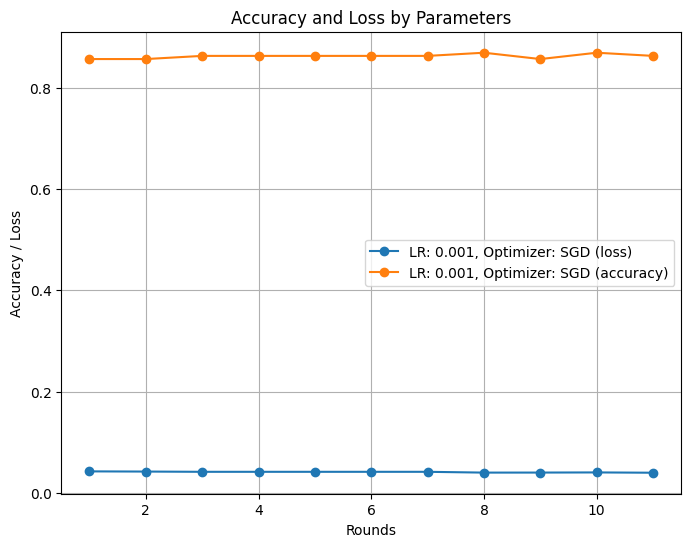

In [20]:
# Make some plots 
global_accuracy,global_loss = ppl_1.server.accuracies,ppl_1.server.losses
results_dict = {
    ('LR: 0.001, Optimizer: SGD', 'accuracy'): global_accuracy,
    ('LR: 0.001, Optimizer: SGD', 'loss'): global_loss
}
plotter = AccuracyLossPlotter(results_dict)

plotter.plot_accuracy_loss()

In [21]:
# Test the Modal on the Test nodes and store the results on the DB
ppl_1.auto_test()

[{'node_name': 'hospital_1',
  'classification_report': "{'confusion matrix': {'TP': 20, 'FP': 28, 'FN': 45, 'TN': 265}, 'Accuracy': 0.796, 'Sensitivity/Recall': 0.308, 'Specificity': 0.904, 'PPV/Precision': 0.417, 'NPV': 0.855, 'F1-score': 0.354, 'False positive rate': 0.096, 'True positive rate': 0.308}"},
 {'node_name': 'hospital_2',
  'classification_report': "{'confusion matrix': {'TP': 18, 'FP': 26, 'FN': 39, 'TN': 275}, 'Accuracy': 0.818, 'Sensitivity/Recall': 0.316, 'Specificity': 0.914, 'PPV/Precision': 0.409, 'NPV': 0.876, 'F1-score': 0.356, 'False positive rate': 0.086, 'True positive rate': 0.316}"},
 {'node_name': 'hospital_3',
  'classification_report': "{'confusion matrix': {'TP': 28, 'FP': 16, 'FN': 43, 'TN': 272}, 'Accuracy': 0.836, 'Sensitivity/Recall': 0.394, 'Specificity': 0.944, 'PPV/Precision': 0.636, 'NPV': 0.863, 'F1-score': 0.487, 'False positive rate': 0.056, 'True positive rate': 0.394}"},
 {'node_name': 'hospital_4',
  'classification_report': "{'confusion m

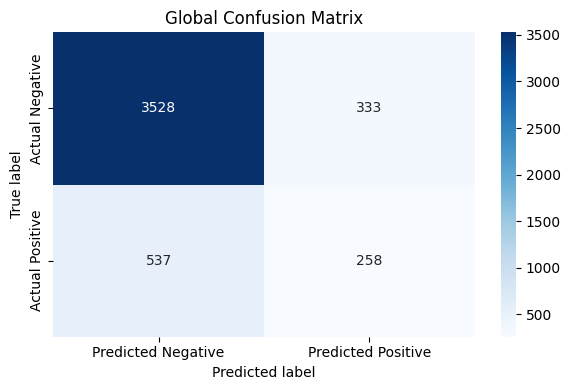

In [22]:
# Plot the Global confusion Matrix of the pipiline "the first fl_pipeline"
AccuracyLossPlotter.plot_global_confusion_matrix(pipeline_name="the first fl_pipeline")

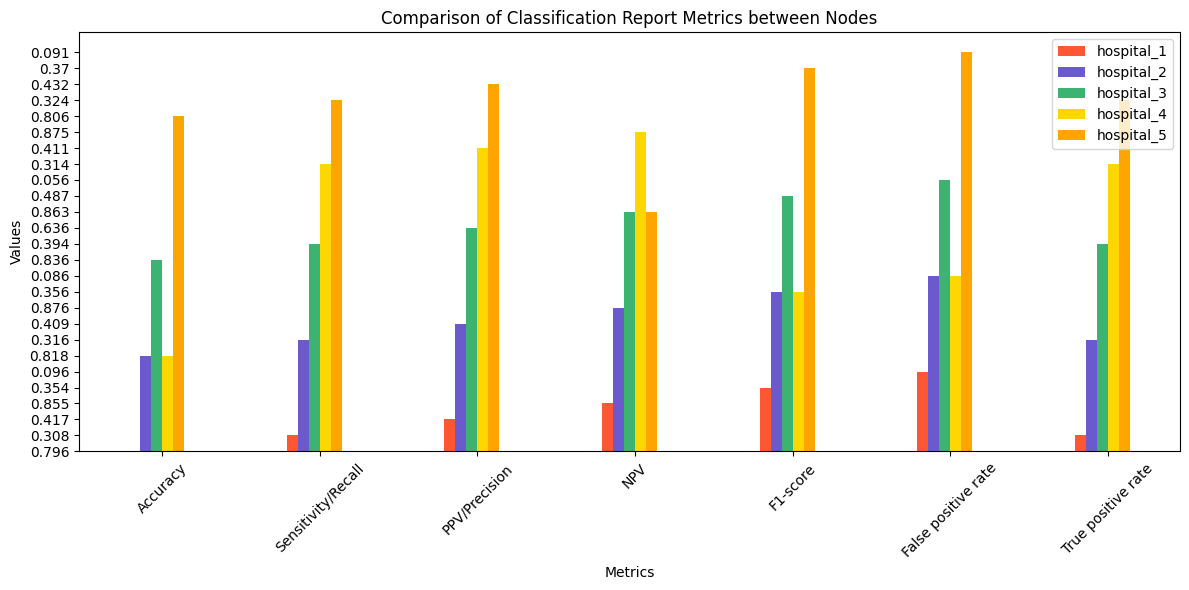

In [23]:
AccuracyLossPlotter.plot_classification_report(pipeline_name="the first fl_pipeline")